# 第2章 統計的推測と時系列分析の基礎

## 2.1 統計的推測の基礎

In [10]:
#
# code 2.1
#
# pip install japanize-matplotlib
# 数値処理やデータ解析のためのライブラリ
import numpy as np
import pandas as pd

# グラフ表示用のライブラリ
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

# 乱数のシードを設定
np.random.seed(42)

# 仮想的な母集団（全世帯の年収）を生成
population_income = np.random.lognormal(
    mean=15.5,
    sigma=0.5,
    size=100000 # サンプルサイズ
)

 母集団の平均年収: 6111262.04
 母集団の標準偏差: 3254959.76


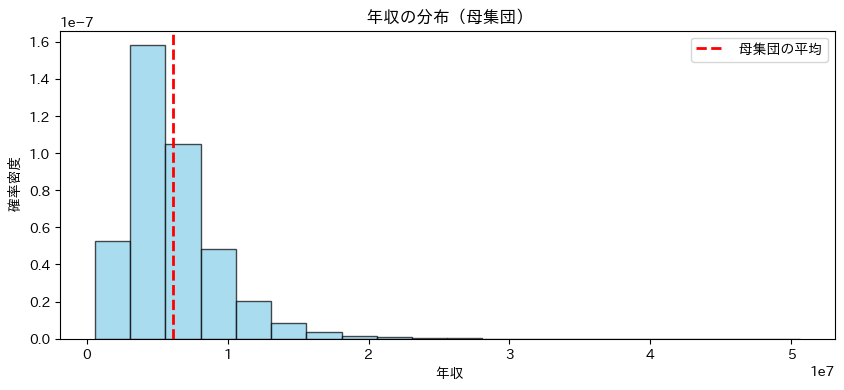

In [11]:
#
# code 2.2
#

# 平均と標準偏差を計算
population_mean = np.mean(population_income)
population_std = np.std(population_income)
print(f" 母集団の平均年収: {population_mean:.2f}")
print(f" 母集団の標準偏差: {population_std:.2f}")

# 母集団のヒストグラム（分布）をプロット
fig, ax = plt.subplots(figsize=(10, 4))
plt.hist(
    population_income, # データ
    bins=20,           # グラフの分割数
    density=True,      # 確率密度関数を描画
    alpha=0.7,         # 透明度
    color='skyblue',   # グラフの色
    edgecolor='black'  # 枠色
)
plt.axvline(
    population_mean,
    color='red',
    linestyle='dashed',
    linewidth=2,
    label=' 母集団の平均'
)
plt.title(' 年収の分布（母集団）')
plt.xlabel(' 年収')
plt.ylabel(' 確率密度')
plt.legend()
plt.show()

In [12]:
#
# code 2.3
#

# サンプルを抽出（100 世帯）
sample_size = 100
sample_income = np.random.choice(
    population_income,
    size=sample_size,
    replace=False
)

# 平均と標準偏差を計算
sample_mean = np.mean(sample_income)

# サンプル標準偏差（不偏分散、ddof=1）を計算
sample_std = np.std(sample_income, ddof=1)

print(f" サンプルの平均年収: {sample_mean:.2f}")
print(f" サンプルの標準偏差: {sample_std:.2f}")

 サンプルの平均年収: 6189692.82
 サンプルの標準偏差: 3847968.16


In [13]:
#
# code 2.4
#

from scipy import stats

# 標準誤差
sample_se = sample_std / np.sqrt(sample_size)
confidence_interval = stats.t.interval(
    0.95,               # 95% 信頼区間
    df=sample_size - 1, # 自由度（サンプルサイズ－ 1）
    loc=sample_mean,    # サンプル平均
    scale=sample_se     # 標準誤差
)

print(f" 平均年収の95% 信頼区間: {confidence_interval}")

 平均年収の95% 信頼区間: (np.float64(5426172.458411219), np.float64(6953213.190320864))


In [14]:
#
# code 2.5
#

from scipy import stats

n = 10 # 試行回数
k = 7  # 表が出た回数

# p を 0 から1 まで 0.01 刻みで用意
p_candidates = np.linspace(0, 1, 101)

# 二項分布の確率質量関数を使って 尤度(L) を計算
likelihoods = [
    stats.binom.pmf(k, n, p) for p in p_candidates
]

# 尤度が最大となる p を探す
mle = p_candidates[np.argmax(likelihoods)]

print(f" 最尤推定法による推定値: {mle:.2f}")

 最尤推定法による推定値: 0.70


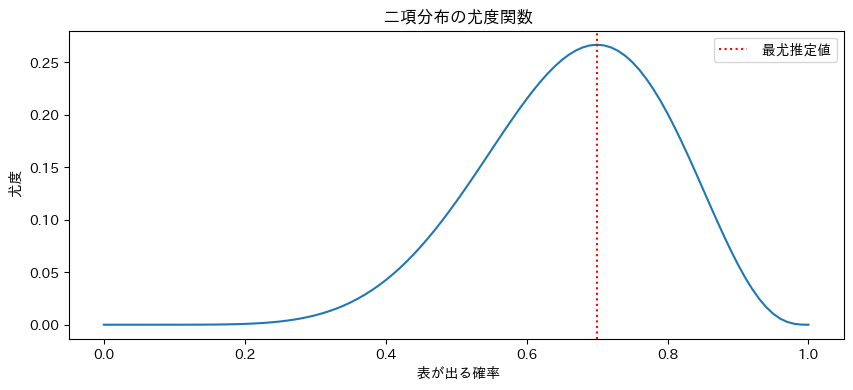

In [15]:
#
# code 2.6
#

# グラフのサイズを設定( 横10、縦4)
fig, ax = plt.subplots(figsize=(10, 4))

# 尤度関数のプロット
plt.plot(
    p_candidates, # x 軸: 確率のパラメータp
    likelihoods   # y 軸: 各p に対する尤度
)

# 最尤推定値を示す垂直線を追加
plt.axvline(
    mle,              # x 座標: 最尤推定値
    color='r',        # 線の色: 赤
    linestyle=':',    # 線のスタイル: 点線
    label=' 最尤推定値' # 凡例のラベル
)

# グラフのタイトルと軸ラベルを設定
plt.title(' 二項分布の尤度関数')
plt.xlabel(' 表が出る確率')
plt.ylabel(' 尤度')
plt.legend() # 凡例を表示
plt.show()   # グラフを表示

In [16]:
#
# code 2.7
#

from scipy.optimize import minimize_scalar

# サンプルデータ（例: 1 が表, 0 が裏）
x_values = np.array([
    1, 1, 1, 1, 1, 1, 1, 0, 0, 0
])

# 誤差関数を定義
def error_function(p):
    return np.sum((x_values - p)**2)

# 誤差関数を最小化するp を求める
result = minimize_scalar(
    error_function, # 最小化する誤差関数
    bounds=(0, 1), # p の範囲は0 から1（確率の範囲）
)

# 最小二乗法による推定値（表が出る確率）を取得
least_squares_p = result.x

print(f" 最小二乗法による推定値: {least_squares_p:.2f}")

 最小二乗法による推定値: 0.70


In [17]:
#
# code 2.8
#

import pymc as pm

# 試行回数と表が出た回数を設定
n = 10 # 試行回数
k = 7  # 表が出た回数

# PyMC モデルの作成
with pm.Model() as coin_model:

    # p の事前分布としてのBeta 分布を設定
    p = pm.Beta('p', alpha=1, beta=1)

    # 観測データに基づく尤度（二項分布）
    likelihood = pm.Binomial(
        'likelihood',
        n=n,
        p=p,
        observed=k
    )

    # MCMC サンプリングの実行
    trace = pm.sample(
        10000, # バーイン後のサンプリング数
        tune=1000, # バーインのサンプリング数
        chains=2, # チェーン数
        random_seed=42, # 乱数シード
    )

# 事後分布のサンプルをFlatten（1 次元化）
posterior_p = trace.posterior['p'].values.flatten()

# 事後分布の平均と標準偏差を計算
p_mean = np.mean(posterior_p)
p_std = np.std(posterior_p)

print(f" 事後分布の推定平均: {p_mean:.2f}")
print(f" 事後分布の推定標準偏差: {p_std:.3f}")

Output()

 事後分布の推定平均: 0.67
 事後分布の推定標準偏差: 0.130


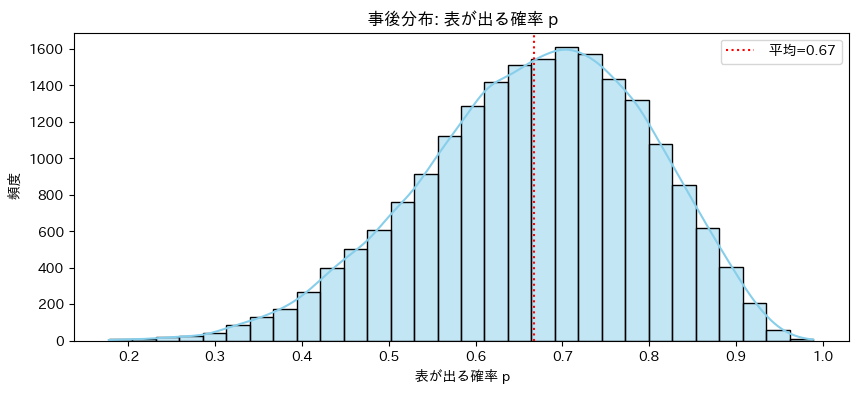

In [18]:
#
# code 2.9
#

# グラフのサイズを設定
fig, ax = plt.subplots(figsize=(10, 4))

# 事後分布のヒストグラムを描画
sns.histplot(
    posterior_p,    # 事後分布のサンプル
    bins=30,        # ビンの数
    kde=True,       # カーネル密度推定を表示
    color='skyblue' # グラフの色
)

# グラフのタイトルと軸ラベルを設定
plt.title(' 事後分布: 表が出る確率 p')
plt.xlabel(' 表が出る確率 p')
plt.ylabel(' 頻度')

# 平均値を示す垂直線を追加
plt.axvline(
    p_mean,                    # 事後分布の平均値
    color='red',               # 線の色
    linestyle=':',             # 線のスタイル
    label=f' 平均={p_mean:.2f}' # 凡例のラベル
)
plt.legend() # 凡例を表示
plt.show()   # グラフを表示

In [19]:
#
# code 2.10
#

# ダイエット結果（体重変化量）のサンプルデータを生成
np.random.seed(42)      # 乱数シードを設定
wl = np.random.normal(  # 正規分布
    2.1, # 平均値
    1.0, # 標準偏差
    50   # サンプルサイズ
)

In [20]:
#
# code 2.11
#

from scipy import stats

# 帰無仮説「平均は2kg と等しい」を検定
# scipy.stats のt 検定（1 標本のt 検定）を実行
t_stat, p_value = stats.ttest_1samp(wl, 2)

print(f"サンプル平均: {np.mean(wl):.2f}kg")
print(f"t 統計量: {t_stat:.4f}")
print(f"p 値: {p_value:.4f}")

サンプル平均: 1.87kg
t 統計量: -0.9503
p 値: 0.3466


## 2.4 時系列データの成分分解

In [22]:
 !pip install wbdata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
  Attempting uninstall: decorator
    Found existing installation: decorator 4.4.2
    Uninstalling decorator-4.4.2:
      Successfully uninstalled decorator-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
bigframes 2.15.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.
moviepy 1.0.3 requires decorator<5.0,>=4.0.2, but you have decorator 5.2.1 which is incompatible.


NameError: name 'plt' is not defined

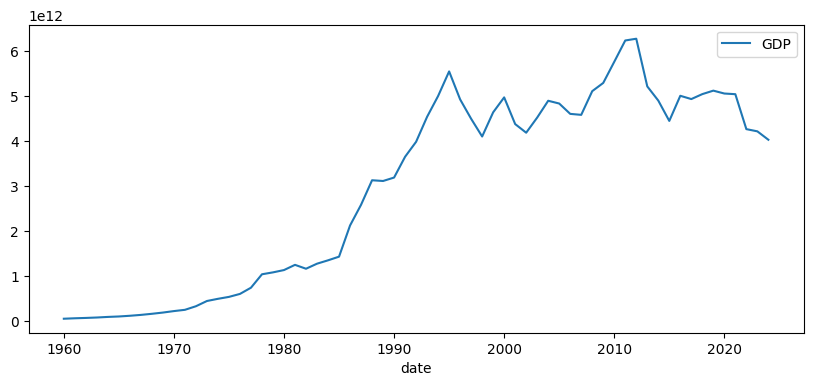

In [2]:
#
# code 2.12
#

import wbdata

# 日本のGDP データを世界銀行から取得
j_gdp = wbdata.get_dataframe(
    {'NY.GDP.MKTP.CD': 'GDP'}, # 世界銀行のGDP
    country='JP'               # 国コード（日本）
)

# インデックス（年）で昇順にソート
j_gdp = j_gdp.sort_index(ascending=True)

# 日本のGDP をプロット
j_gdp.plot(figsize=(10, 4))
plt.title(' 日本のGDP 推移')
plt.xlabel(' 年')
plt.ylabel('GDP ( 米ドル)')
plt.show()

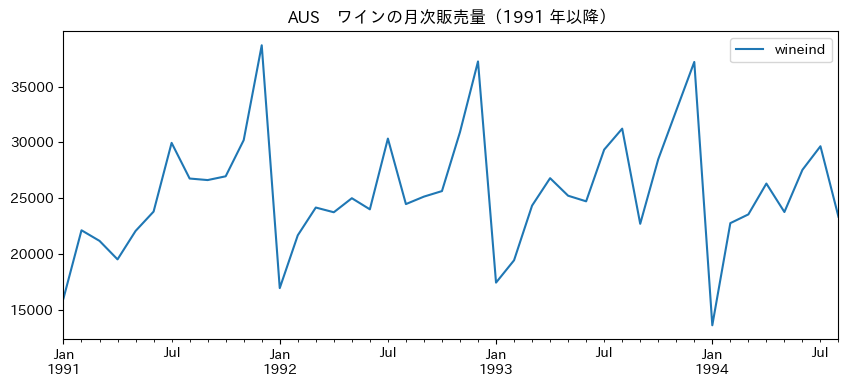

In [ ]:
#
# code 2.13
#

from pmdarima.datasets import load_wineind

# データの読み込みデータフレームに変換
wine = pd.DataFrame(
    load_wineind(),
    columns=['wineind']
)

# インデックスを日付に変更
wine.index = pd.date_range(
    start='1980-01-01',
    periods=wine.shape[0],
    freq='M'
)

# 1991 年以降をプロット
wine.loc['1991':].plot(figsize=(10, 4))
plt.title('AUS　ワインの月次販売量（1991 年以降）')
plt.show()

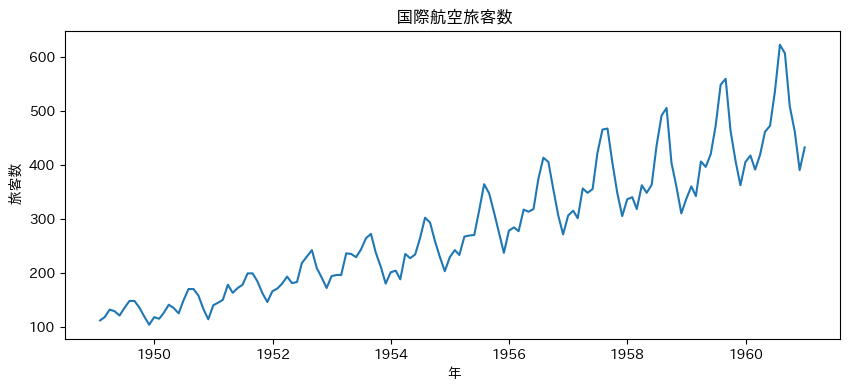

In [ ]:
#
# code 2.14
#

from pmdarima.datasets import load_airpassengers

# データの読み込み
data = load_airpassengers()
df_ap = pd.DataFrame(data, columns=['y'])
df_ap.index = pd.date_range(
    start='1949-01-01', # 開始月
    periods=len(df_ap), # 期数
    freq='M'            # 間隔（M は月を意味する）
)

# データのプロット
plt.figure(figsize=(10, 4))
plt.plot(df_ap.index, df_ap['y'])
plt.title(' 国際航空旅客数')
plt.xlabel(' 年')
plt.ylabel(' 旅客数')
plt.show()

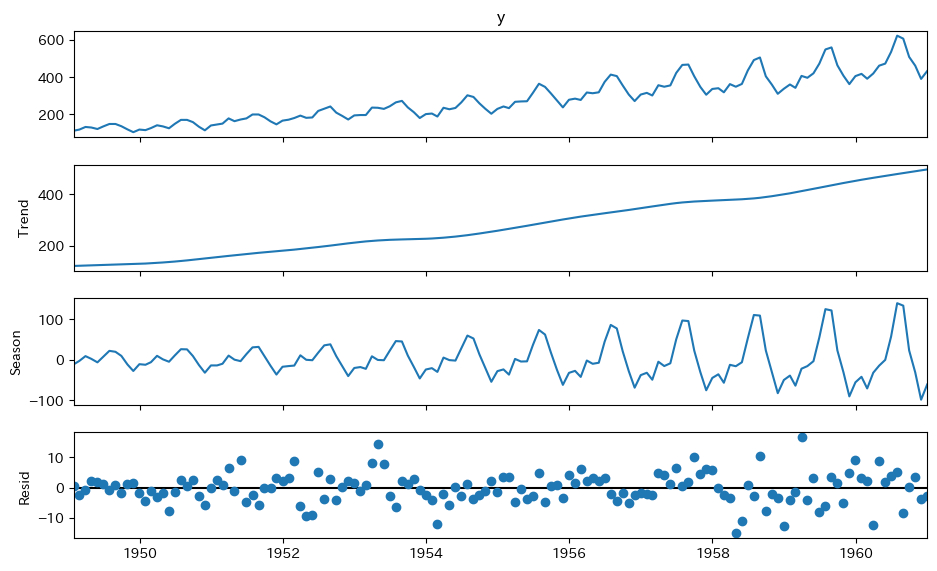

In [ ]:
#
# code 2.15
#

from statsmodels.tsa.seasonal import STL

# STL 分解の実施
stl = STL(
    df_ap['y'], # データ
    period=12,  # 季節周期
)
res = stl.fit()

# 結果のプロット
fig = res.plot()
plt.gcf().set_size_inches(10, 6)
plt.show()

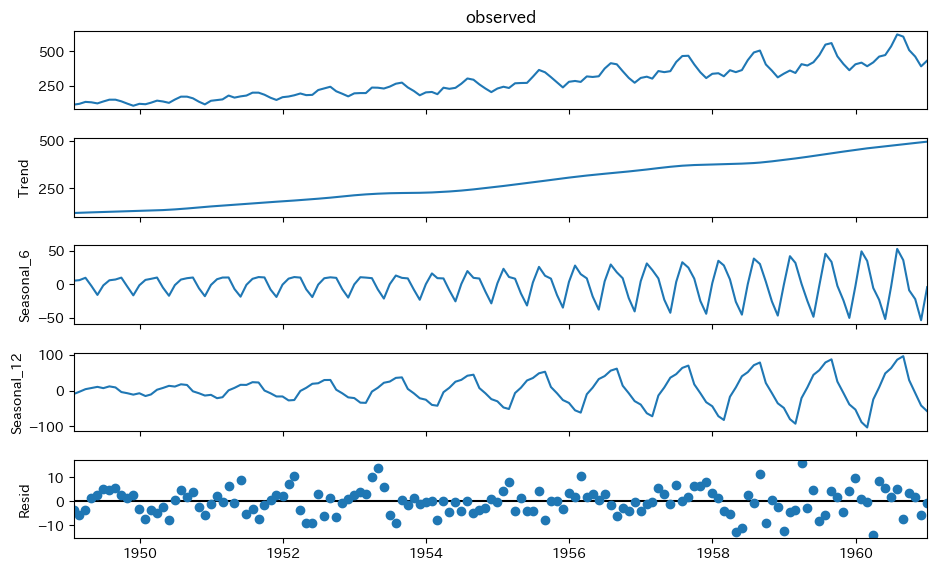

In [ ]:
#
# code 2.16
#

from statsmodels.tsa.seasonal import MSTL

# MSTL 分解の実施
mstl = MSTL(
    df_ap['y'],      # データ
    periods=[6, 12], # 周期
)
res = mstl.fit()

# MSTL 分解結果のプロット
fig = res.plot()
plt.gcf().set_size_inches(10, 6)
plt.show()

## 2.5 自己相関と偏自己相関

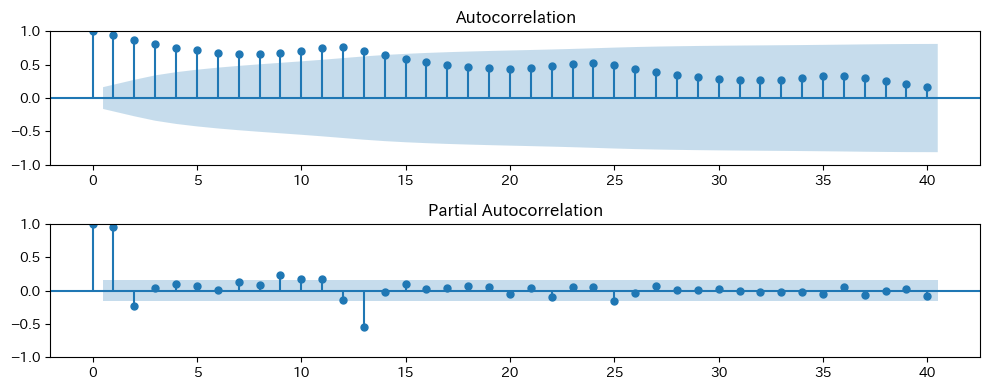

In [ ]:
#
# code 2.17
#

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(10, 4))
plot_acf(df_ap['y'], ax=ax[0], lags=40)  # 自己相関
plot_pacf(df_ap['y'], ax=ax[1], lags=40) # 偏自己相関
plt.tight_layout()
plt.show()

## 2.6 定常性と非定常性

In [ ]:
#
# code 2.18
#

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

# ADF 検定を行う関数
def adf_test(
    series, # 時系列データ
    reg='c', # 'c' ( 定数項のみ), 'ct' ( 定数+ トレンド) など指定
):
    result = adfuller(series.dropna(), regression=reg)

    print("=== ADF 検定結果 ===")
    print(f" 検定統計量 (ADF Statistic) : {result[0]:.4f}")
    print(f"p 値 (p-value) : {result[1]:.4f}")
    if result[1] < 0.05:
        print(" 帰無仮説を棄却 → 定常\n")
    else:
        print(" 帰無仮説が棄却できず → 非定常かもしれない\n")

# KPSS 検定を行う関数
def kpss_test(
    series, # 時系列データ
    reg='c', # 'c' ( 定数項のみ), 'ct' ( 定数+ トレンド) など指定
):
    result = kpss(series.dropna(), regression=reg)

    print("=== KPSS 検定結果 ===")
    print(f" 検定統計量 (KPSS Statistic): {result[0]:.4f}")
    print(f"p 値 (p-value) : {result[1]:.4f}")
    if result[1] < 0.05:
        print(" 帰無仮説を棄却 → 非定常\n")
    else:
        print(" 帰無仮説が棄却できず → 定常かもしれない\n")

In [ ]:
#
# code 2.19
#

adf_test(df_ap['y'], reg='c')
kpss_test(df_ap['y'], reg='c')

=== ADF 検定結果 ===
 検定統計量 (ADF Statistic) : 0.8154
p 値 (p-value) : 0.9919
 帰無仮説が棄却できず → 非定常かもしれない

=== KPSS 検定結果 ===
 検定統計量 (KPSS Statistic): 1.6513
p 値 (p-value) : 0.0100
 帰無仮説を棄却 → 非定常



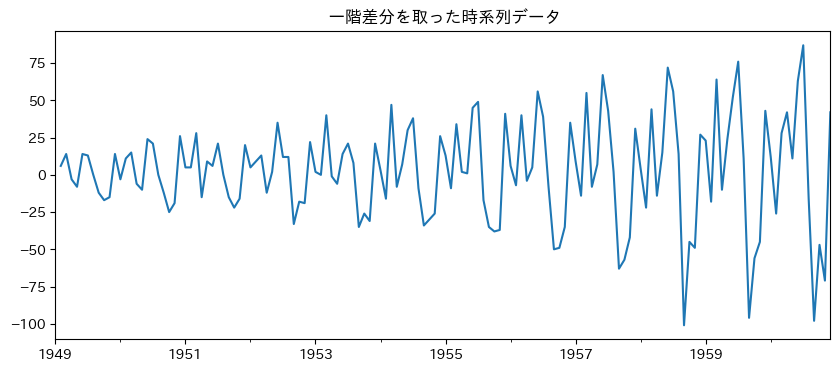

In [ ]:
#
# code 2.20
#

# 一階差分
df_lag1 = df_ap['y'].diff()

# プロット
plt.figure(figsize=(10, 4))
df_lag1.plot()
plt.title(' 一階差分を取った時系列データ')
plt.show()

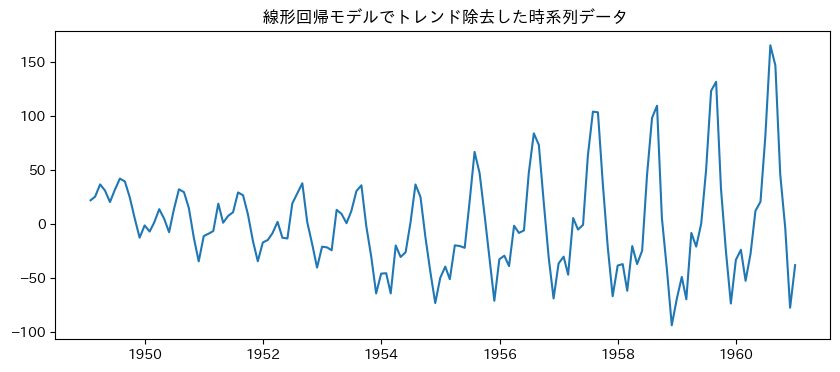

In [ ]:
#
# code 2.21
#

from sklearn.linear_model import LinearRegression

t = np.arange(len(df_ap)).reshape(-1, 1) # 時間t
y = df_ap['y'].values                    # 旅客数をnumpy 配列に変換

# t による線形回帰モデルの学習
model = LinearRegression()
model.fit(t, y)

# トレンドを予測
trend = model.predict(t)

# トレンド除去
df_detrended = df_ap['y'] - trend

# プロット
plt.figure(figsize=(10, 4))
plt.plot(df_detrended.index, df_detrended)
plt.title(' 線形回帰モデルでトレンド除去した時系列データ')
plt.show()

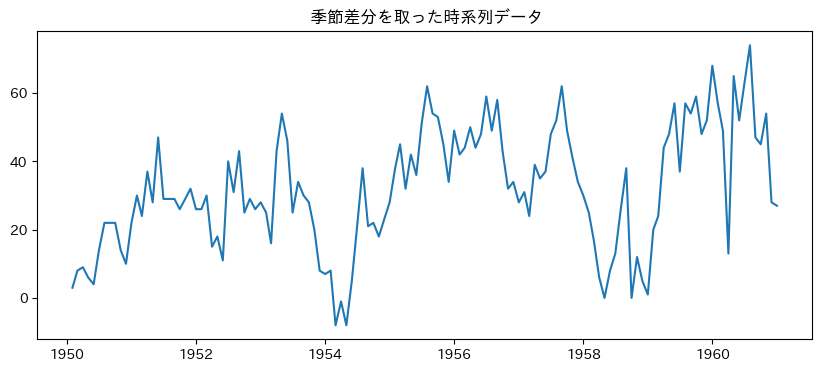

In [ ]:
#
# code 2.22
#

# 季節差分
df_des = df_ap['y'].diff(12)

# プロット
plt.figure(figsize=(10, 4))
plt.plot(df_des.index, df_des)
plt.title(' 季節差分を取った時系列データ')
plt.show()

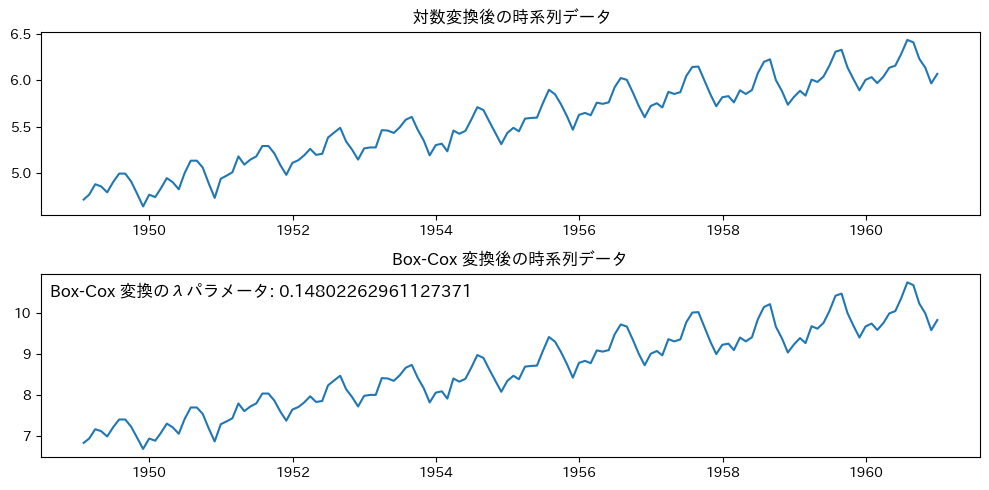

In [ ]:
#
# code 2.23
#

# 対数変換
df_log = np.log(df_ap['y'])

# Box-Cox 変換（scipy を利用）
df_bc, lambda_param = stats.boxcox(df_ap['y'])

# プロット
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].plot(df_log.index, df_log)
ax[0].set_title(' 対数変換後の時系列データ')
ax[1].plot(df_ap.index, df_bc)
ax[1].set_title('Box-Cox 変換後の時系列データ')
ax[1].text(
    0.01, 0.95,
    f"Box-Cox 変換のλパラメータ: {lambda_param}",
    ha="left", va="top", fontsize=12,
    transform=ax[1].transAxes
)
plt.tight_layout()
plt.show()

In [ ]:
#
# code 2.24
#

def plot_and_stationarity_tests(
    series, # 時系列データ
    title, # グラフタイトル
    adf_reg='c', # ADF 検定での回帰モデル指定
    kpss_reg='c' # PSS 検定での回帰モデル指定
):
    # 時系列プロット・コレログラム
    plt.figure(figsize=(12, 6))

    # (a) 時系列プロット
    plt.subplot(311)
    plt.plot(series)
    plt.title(title)

    # (b) ACF コレログラム
    plt.subplot(312)
    plot_acf(series.dropna(), ax=plt.gca(), lags=40)

    # (c) PACF コレログラム
    plt.subplot(313)
    plot_pacf(series.dropna(), ax=plt.gca(), lags=40)
    plt.tight_layout()
    plt.show()

    # ADF 検定
    adf_test(series, reg=adf_reg)

    # KPSS 検定
    kpss_test(series, reg=kpss_reg)

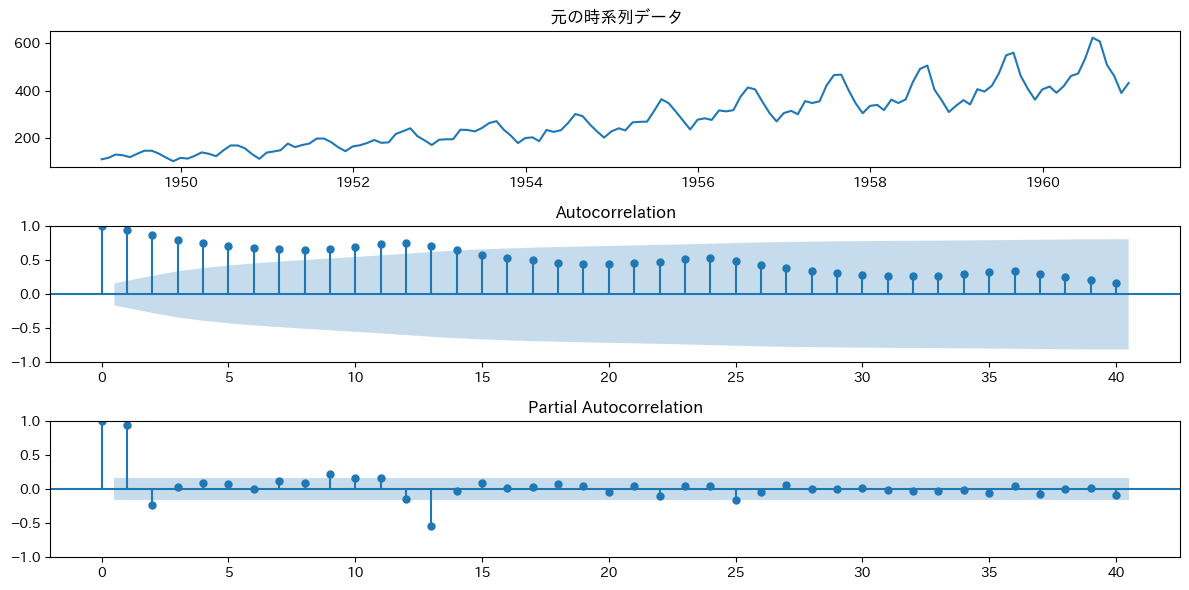

=== ADF 検定結果 ===
 検定統計量 (ADF Statistic) : 0.8154
p 値 (p-value) : 0.9919
 帰無仮説が棄却できず → 非定常かもしれない

=== KPSS 検定結果 ===
 検定統計量 (KPSS Statistic): 1.6513
p 値 (p-value) : 0.0100
 帰無仮説を棄却 → 非定常



In [ ]:
#
# code 2.25
#

# 検討1：元のデータ（原系列）
plot_and_stationarity_tests(
    df_ap['y'],
    title=' 元の時系列データ',
)

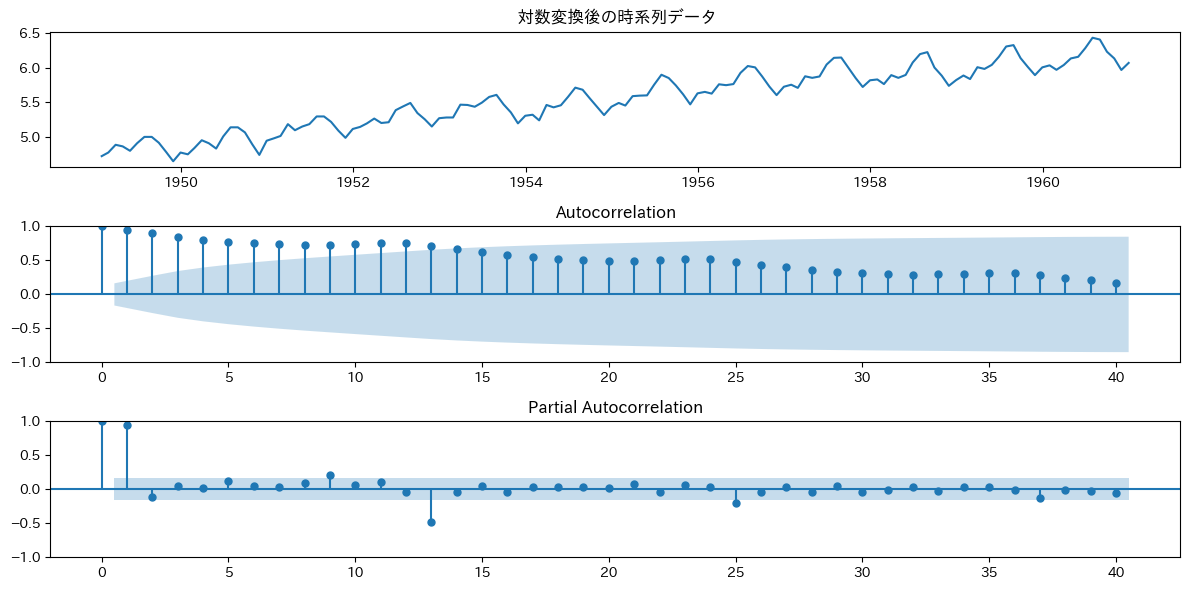

=== ADF 検定結果 ===
 検定統計量 (ADF Statistic) : -1.7170
p 値 (p-value) : 0.4224
 帰無仮説が棄却できず → 非定常かもしれない

=== KPSS 検定結果 ===
 検定統計量 (KPSS Statistic): 1.6687
p 値 (p-value) : 0.0100
 帰無仮説を棄却 → 非定常



In [ ]:
#
# code 2.26
#

# 検討2：対数変換
df_log = np.log(df_ap['y'])
plot_and_stationarity_tests(
    df_log,
    title=' 対数変換後の時系列データ'
)

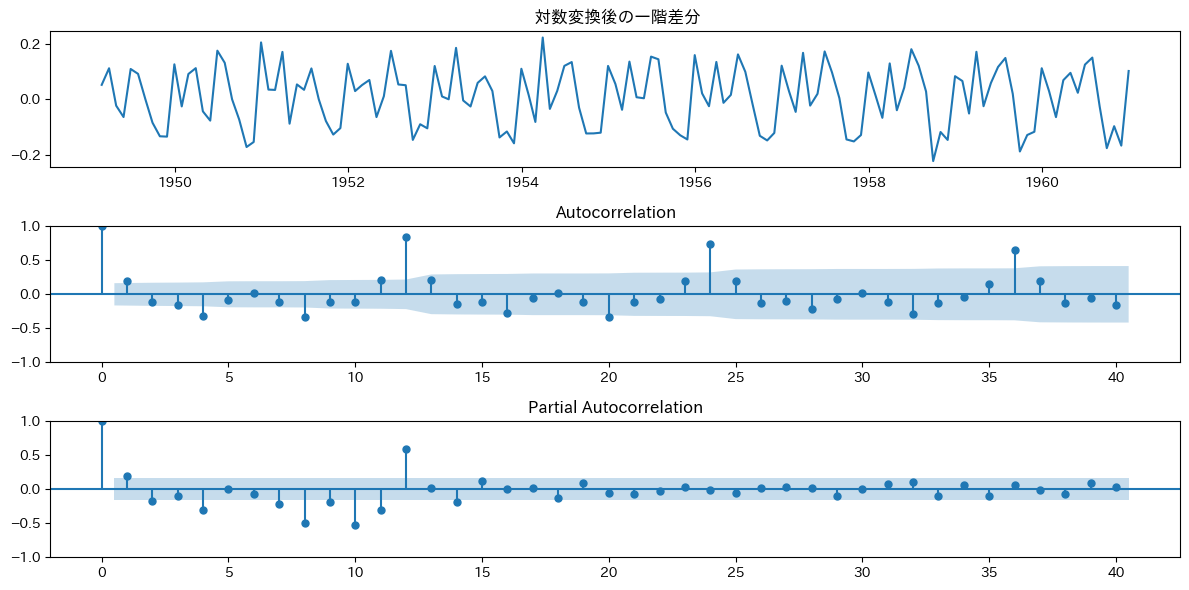

=== ADF 検定結果 ===
 検定統計量 (ADF Statistic) : -2.7171
p 値 (p-value) : 0.0711
 帰無仮説が棄却できず → 非定常かもしれない

=== KPSS 検定結果 ===
 検定統計量 (KPSS Statistic): 0.0383
p 値 (p-value) : 0.1000
 帰無仮説が棄却できず → 定常かもしれない



In [ ]:
#
# code 2.27
#

# 検討3：一階差分
df_log_diff = df_log.diff()
plot_and_stationarity_tests(
    df_log_diff,
    title=' 対数変換後の一階差分'
)

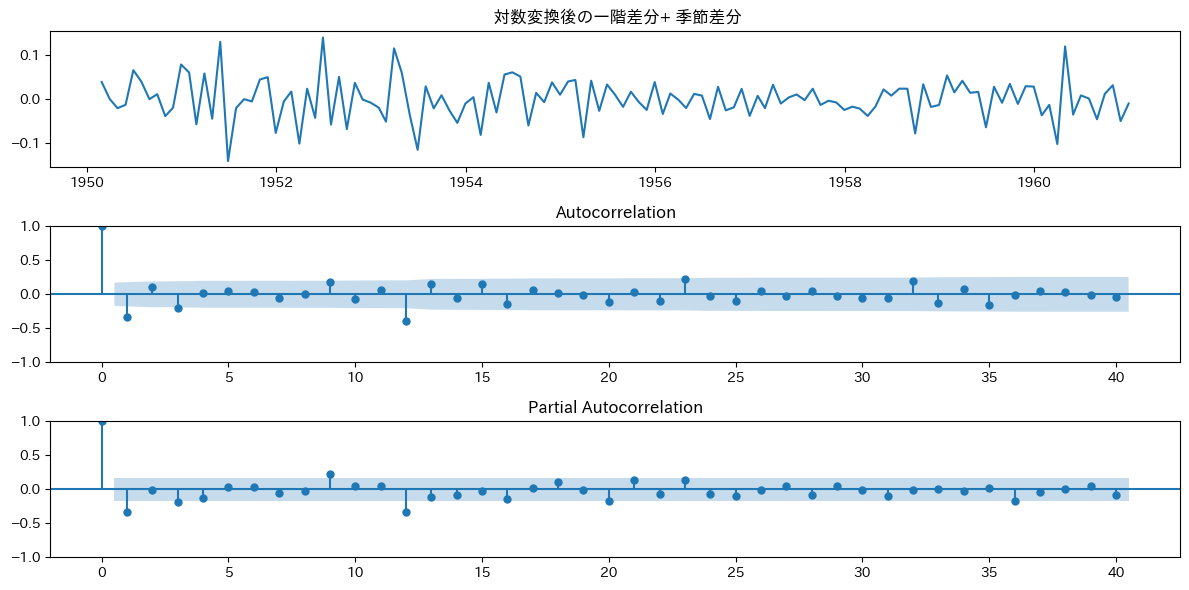

=== ADF 検定結果 ===
 検定統計量 (ADF Statistic) : -4.4433
p 値 (p-value) : 0.0002
 帰無仮説を棄却 → 定常

=== KPSS 検定結果 ===
 検定統計量 (KPSS Statistic): 0.0732
p 値 (p-value) : 0.1000
 帰無仮説が棄却できず → 定常かもしれない



In [ ]:
#
# code 2.28
#

# 検討4：季節差分 (12 期差分)
df_log_diff_seasonal = df_log_diff.diff(12)
plot_and_stationarity_tests(
    df_log_diff_seasonal,
    title=' 対数変換後の一階差分+ 季節差分',
)

# 2.7 周期期間の検討方法

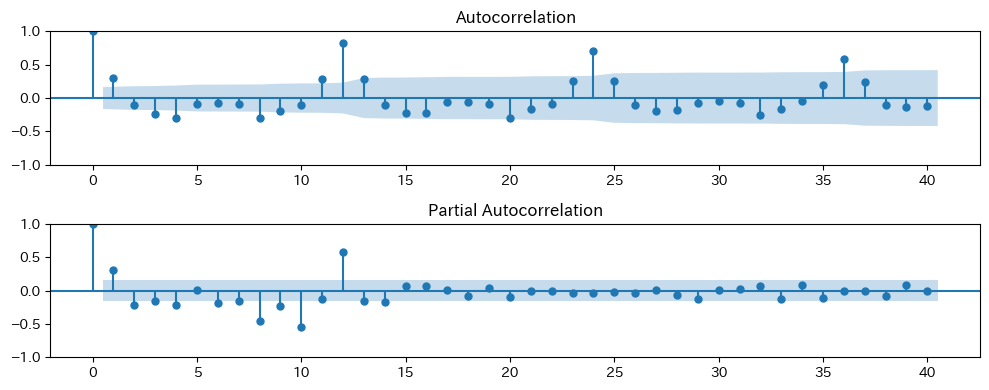

In [ ]:
#
# code 2.29
#

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 差分処理（トレンド除去）
df_diff = df_ap.diff().dropna()

# コレログラム
fig, axes = plt.subplots(2, 1, figsize=(10, 4))
plot_acf(df_diff['y'], lags=40, ax=axes[0])
plot_pacf(df_diff['y'], lags=40, ax=axes[1])
plt.tight_layout()
plt.show()

In [ ]:
#
# code 2.30
#

from scipy.signal import argrelextrema

# 差分処理（トレンド除去）
df_diff = df_ap.diff().dropna()

# 高速フーリエ変換（FFT）の実行
y = df_diff['y'].values            # 時系列データをnumpy 配列に変換
N = y.size                         # データ数
T = 1.0                            # サンプリング間隔
yf = np.fft.fft(y)                 # FFT 実施
xf = np.fft.fftfreq(N, d=T)[:N//2] # 周波数軸の生成

# パワースペクトルを計算
power_spectrum = 2.0/N * np.abs(yf[0:N//2])

# ピーク（極大値）探索
peaks = argrelextrema(power_spectrum, np.greater)
peak_freqs = xf[peaks]                  # ピークの周波数
peak_powers = power_spectrum[peaks]     # ピークのパワー
peak_periods_in_months = 1 / peak_freqs # 周期に変換

# ピークの周期とパワーの一覧表を作成
peaks_df = pd.DataFrame({
    ' 周期〔月〕': peak_periods_in_months.round(0),
    ' パワー': peak_powers.round(4)
})
peaks_df = peaks_df.sort_values(' パワー', ascending=False)
print(peaks_df.head())

     周期〔月〕      パワー
5      6.0  24.8054
3     12.0  23.5504
8      4.0  12.0342
10     3.0  10.2364
13     2.0   9.4752


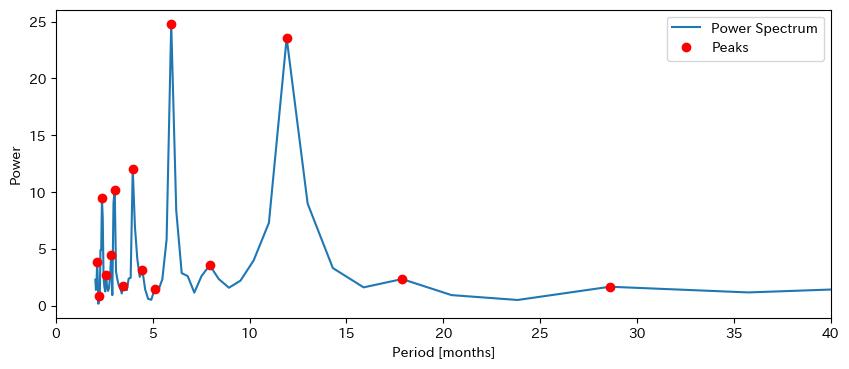

In [ ]:
#
# code 2.31
#

mask = xf != 0   # 0周波数を除外
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_xlim(0, 40)
ax.plot(                    # パワースペクトルのプロット
    1/xf[mask],             # x軸：周期
    power_spectrum[mask],   # y軸：パワー
    label='Power Spectrum'  # 凡例
)
ax.plot(                    # ピークのプロット
    peak_periods_in_months, # x軸：ピークの周期
    peak_powers,            # y軸：ピークのパワー
    'ro',                   # 赤い点でプロット
    label='Peaks'           # 凡例
)
ax.set_xlabel('Period [months]')
ax.set_ylabel('Power')
ax.legend()
plt.show()

# 2.8 相互相関とインパルス応答関数

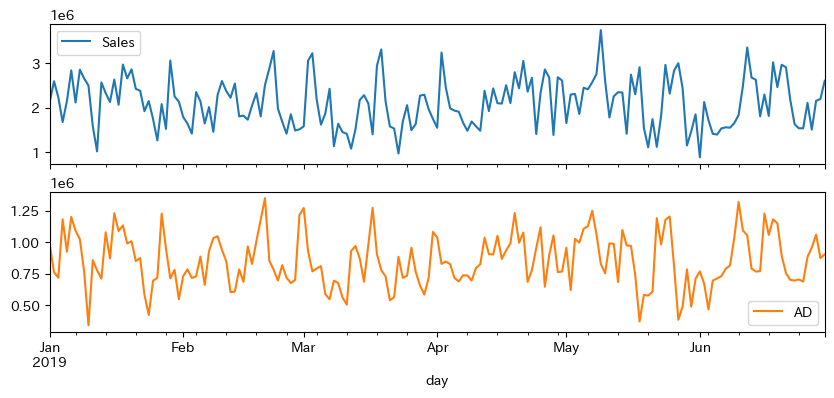

In [ ]:
#
# code 2.32
#

# データセット読み込み
df = pd.read_csv(
    'MMM_day.csv',
    parse_dates=True,
    index_col='day'
)

# プロット
df.plot(
    subplots=True,
    figsize=(10, 4),
    legend=True
)
plt.show()

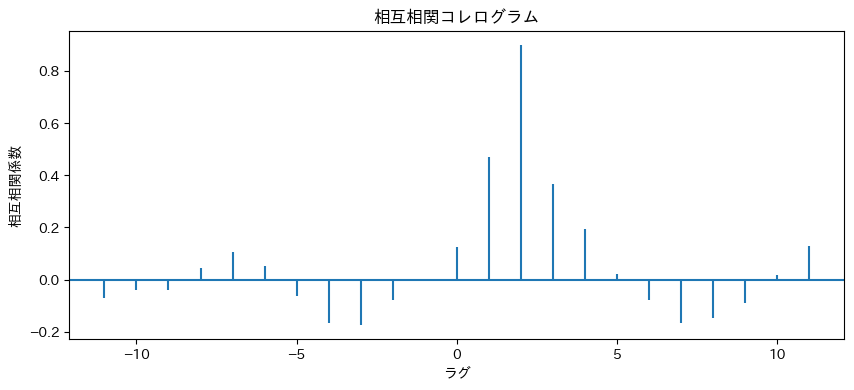

In [ ]:
#
# code 2.33
#

from matplotlib import mlab

# 相互相関コレログラム
plt.figure(figsize=(10, 4))
xcor_value = plt.xcorr(
    df['Sales'],
    df['AD'],
    detrend=mlab.detrend_linear, # 線形トレンド除去
    maxlags=11,                  # 最大ラグ
)
plt.title('相互相関コレログラム')
plt.xlabel('ラグ')
plt.ylabel('相互相関係数')
plt.show()

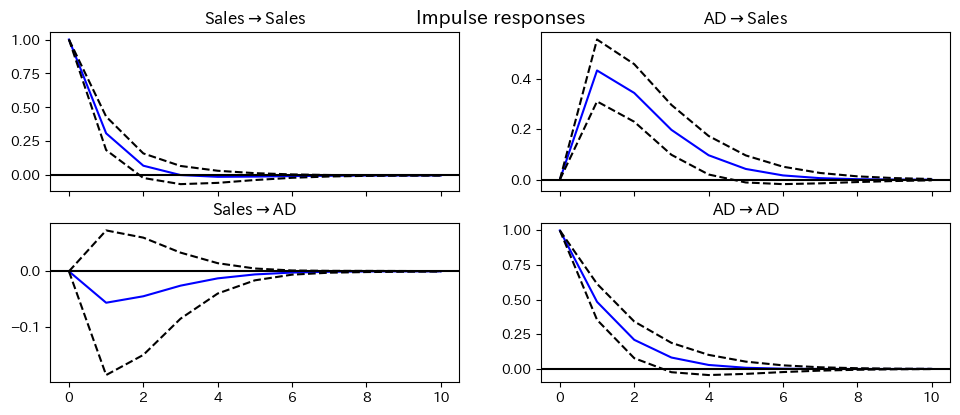

In [ ]:
#
# code 2.34
#

from statsmodels.tsa.api import VAR

# 標準化
df_scaled = (df - df.mean()) / df.std()

# VARモデルの適用
model = VAR(df_scaled)
results = model.fit()

# インパルス応答の計算（10期分）
irf = results.irf(10)

# プロット
irf.plot(orth=False, figsize=(10, 4))
plt.show()

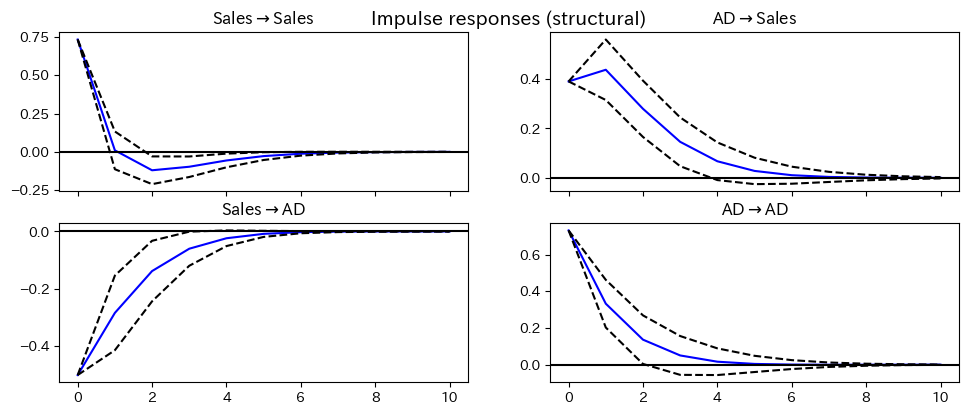

In [ ]:
#
# code 2.35
#

from statsmodels.tsa.api import SVAR

# 標準化
df_scaled = (df - df.mean()) / df.std()

# 行列Aの定義（Eは推定対象を表す）
A = np.array([
    [1, 'E'],
    ['E', 1]
])

# SVARモデルの適用
model = SVAR(df_scaled, svar_type="A", A=A)
results = model.fit()

# 構造的インパルス応答の計算（10期分）
irf = results.irf(10)

# プロット
irf.plot(figsize=(10, 4))
plt.show()

In [ ]:
#
# code 2.36
#

from statsmodels.tsa.stattools import grangercausalitytests

# 最大ラグの設定
max_lags = 5

msg0 = "グレンジャー因果性あり"
msg1 = "グレンジャー因果性なし"

# 売上⇒広告費のグレンジャー因果性検定
print("【売上⇒広告費】グレンジャー因果性検定結果")
test_results = grangercausalitytests(
    x=df[['AD', 'Sales']],  # 結果:AD, 原因:Sales
    maxlag=max_lags,
    verbose=False
)
for lag in range(1, max_lags + 1):
    tstat = test_results[lag][0]['ssr_chi2test']
    rst = msg0 if tstat[1] < 0.05 else msg1
    print(f"ラグ {lag} : p値={tstat[1]:.4f} ({rst})")

# 広告費⇒売上のグレンジャー因果性検定
print("\n【広告費⇒売上】グレンジャー因果性検定結果")
test_results2 = grangercausalitytests(
    x=df[['Sales','AD']],  # 結果:Sales, 原因:AD
    maxlag=max_lags,
    verbose=False
)
for lag in range(1, max_lags + 1):
    tstat = test_results2[lag][0]['ssr_chi2test']
    rst = msg0 if tstat[1] < 0.05 else msg1
    print(f"ラグ {lag} : p値={tstat[1]:.4f} ({rst})")

【売上⇒広告費】グレンジャー因果性検定結果
ラグ 1 : p値=0.3909 (グレンジャー因果性なし)
ラグ 2 : p値=0.5193 (グレンジャー因果性なし)
ラグ 3 : p値=0.2006 (グレンジャー因果性なし)
ラグ 4 : p値=0.2080 (グレンジャー因果性なし)
ラグ 5 : p値=0.4501 (グレンジャー因果性なし)

【広告費⇒売上】グレンジャー因果性検定結果
ラグ 1 : p値=0.0000 (グレンジャー因果性あり)
ラグ 2 : p値=0.0000 (グレンジャー因果性あり)
ラグ 3 : p値=0.0000 (グレンジャー因果性あり)
ラグ 4 : p値=0.0000 (グレンジャー因果性あり)
ラグ 5 : p値=0.0000 (グレンジャー因果性あり)


# 2.9 時系列データの欠損処理

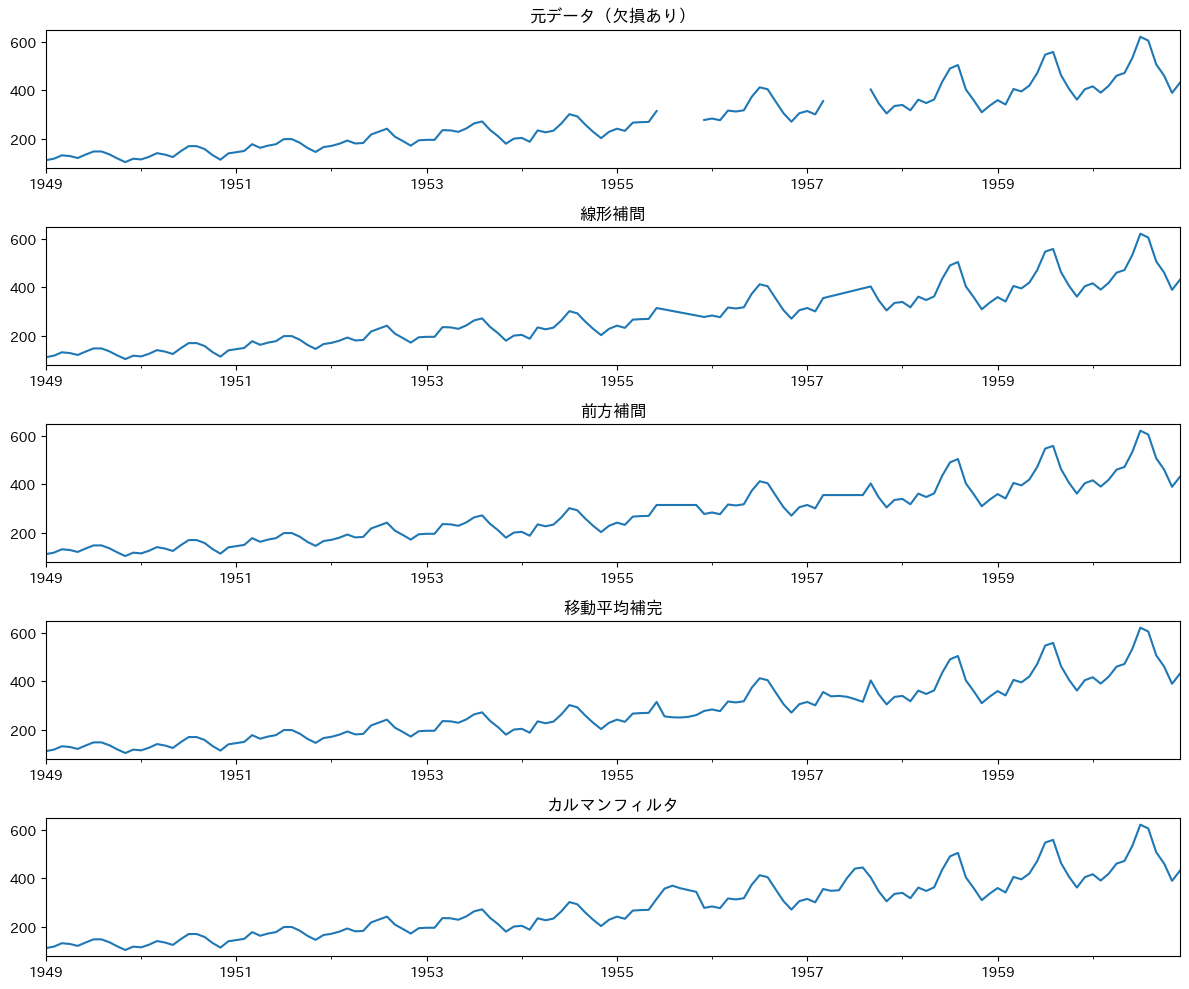

In [ ]:
#
# code 2.37
#

from statsmodels.tsa.statespace.structural import UnobservedComponents

# 一部を欠損値に
data = df_ap.copy()
data.loc['1955-07-01':'1955-12-01'] = np.nan
data.loc['1957-04-01':'1957-09-01'] = np.nan

# 線形補間
data['Linear'] = data['y'].interpolate(method='linear')

# 前方補間
data['FF'] = data['y'].ffill()

# 移動平均補完
data['Rolling_Mean'] = data['y'].copy()
mask = data['Rolling_Mean'].isna()
data.loc[mask, 'Rolling_Mean'] = data['y'].rolling(
    12, min_periods=1
).mean().loc[mask]

# カルマンフィルタ
model = UnobservedComponents(
    data['y'],
    level='local linear trend',
    seasonal=12,
    freq='M'
)
results = model.fit(disp=False)
data['Kalman'] = results.filtered_state[0] + results.filtered_state[2]

# プロット比較
titles = [
    '元データ（欠損あり）',
    '線形補間',
    '前方補間',
    '移動平均補完',
    'カルマンフィルタ'
]
columns = ['y','Linear','FF','Rolling_Mean','Kalman']
fig, axes = plt.subplots(5, 1, figsize=(12, 10))
for idx, (title, col) in enumerate(zip(titles, columns)):
    data[col].plot(ax=axes[idx])
    axes[idx].set_title(title)
    axes[idx].set_xlabel("")
plt.tight_layout()
plt.show()